# Industry Community Detection

_Realize that everything connects to everything else_ - Leonardo DaVinci

Traditional industry classification systems, such as SIC and NAICS, group firms based on production processes or product similarities. Natural language processing techniques can be leveraged to analyze product descriptions and capture dynamic changes in industry structures over time, as proposed by Hoberg and Phillips (2016). Industry communities can be detected through network analysis, where firms are modeled as nodes in a graph, and connections between them are determined by similarities in their product and market descriptions.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import zipfile
import io
from itertools import chain
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from finds.database import SQL
from finds.readers import requests_get, Sectoring
from finds.structured import BusDay, PSTAT
from finds.recipes import graph_info
from secret import credentials
# %matplotlib qt
VERBOSE = 0

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
bd = BusDay(sql)
pstat = PSTAT(sql, bd, verbose=VERBOSE)

## Industry taxonomy

Industry classification, or industry taxonomy, organizes companies into groups based on shared characteristics such as production processes, product offerings, or financial market behaviors. 



### Text-based industry classification

Hoberg and Phillips (2016) developed a text-based measure of firm similarity by analyzing product descriptions in 10-K filings. They construct firm-by-firm similarity scores using word vectors, filtering out common words and focusing on nouns and proper nouns, while excluding geographic terms. The similarity between firms is quantified using cosine similarity, creating a pairwise similarity matrix across firms and years.

Since Item 101 of Regulation S-K mandates that firms accurately describe their key products in their 10-K filings, the TNIC scheme, based on textual similarity, provides a dynamic classification system that evolves with market changes. This method offers a more flexible alternative to traditional classification systems, capturing shifts in product markets over time.

Source: [Hoberg and Phillips Industry Classification](https://hobergphillips.tuck.dartmouth.edu/industryclass.htm)

The TNIC pair-wise firm similiarities are retrieved from the Hoberg and Phillips website:

In [3]:
# Retrieve TNIC scheme from Hoberg and Phillips website
tnic_scheme = 'tnic3'
root = 'https://hobergphillips.tuck.dartmouth.edu/idata/'   
source = root + tnic_scheme + '_data.zip'
if source.startswith('http'):
    response = requests_get(source)
    source = io.BytesIO(response.content)

# extract the csv file from zip archive
with zipfile.ZipFile(source).open(tnic_scheme + "_data.txt") as f:
    tnic_data = pd.read_csv(f, sep='\s+')

# extract latest year of tnic as data frame
year = max(tnic_data['year']) # [1989, 1999, 2009, 2019]
tnic = tnic_data[tnic_data['year'] == year].dropna()
tnic

,year,gvkey1,gvkey2,score
26307358,2023,1004,1823,0.0127
26307359,2023,1004,4091,0.0087
26307360,2023,1004,5567,0.0063
26307361,2023,1004,9698,0.0075
26307362,2023,1004,10519,0.0191
...,...,...,...,...
26973403,2023,351038,329141,0.0684
26973404,2023,351038,331856,0.0769
26973405,2023,351038,332115,0.1036
26973406,2023,351038,347007,0.0731


### Industry classification

Industry classification systems such as SIC and NAICS follow hierarchical structures to categorize firms based on their economic activities:

- **Standard Industrial Classification (SIC)**: Uses a 2-digit, 3-digit, and 4-digit hierarchy to classify industries.
- **North American Industry Classification System (NAICS)**: Expands classification granularity from 2-digit to 6-digit levels.


In [4]:
# populate dataframe of nodes with gvkey (as index), permno, sic and naics
nodes = DataFrame(index=sorted(set(tnic['gvkey1']).union(tnic['gvkey2'])))\
        .rename_axis(index='gvkey')
for code in ['lpermno', 'sic', 'naics']:
    lookup = pstat.build_lookup('gvkey', code, fillna=0)
    nodes[code] = lookup(nodes.index)
Series(np.sum(nodes > 0, axis=0)).rename('Non-missing').to_frame().T

,lpermno,sic,naics
Non-missing,3829,3829,3827


In [6]:
# supplement naics and sic with crosswalks in Sectoring class
naics = Sectoring(sql, 'naics', fillna=0)   # supplement from crosswalk
sic = Sectoring(sql, 'sic', fillna=0)
nodes['naics'] = nodes['naics'].where(nodes['naics'] > 0, naics[nodes['sic']])
nodes['sic'] = nodes['sic'].where(nodes['sic'] > 0, sic[nodes['naics']])
Series(np.sum(nodes > 0, axis=0)).rename('Non-missing').to_frame().T 

,lpermno,sic,naics
Non-missing,3829,3829,3829


### Sector groups

Industry taxonomies group detailed classifications into broader sectors for economic analysis:

- Fama and French aggregate 4-digit SIC codes into industry groups consisting of 5, 10, 12, 17, 30, 38, 48, or 49 sectors.
- The Bureau of Economic Analysis (BEA) consolidates 6-digit NAICS codes into summary-level industry groups, with updates in 1947, 1963, and 1997.


In [7]:
# include sectoring schemes
codes = {'sic': ([f"codes{c}" for c in [5, 10, 12, 17, 30, 38, 48, 49]]
                 + ['sic2', 'sic3']),
         'naics': ['bea1947', 'bea1963', 'bea1997']}
sectorings = {}   # store Sectoring objects
for key, schemes in codes.items():
    for scheme in schemes:
        if scheme not in sectorings:

            # missing value is integer 0 sic2 and sic3 shemes, else string ''
            fillna = 0 if scheme.startswith('sic') else ''

            # load the sectoring class from SQL
            sectorings[scheme] = Sectoring(sql, scheme, fillna=fillna)

            # apply the sectoring scheme to partition the nodes
            nodes[scheme] = sectorings[scheme][nodes[key]]

        # keep nodes with non-missing data
        nodes = nodes[nodes[scheme].ne(sectorings[scheme].fillna)]
        print(len(nodes), scheme)
nodes

3845 codes5
3845 codes10
3845 codes12
3845 codes17
3845 codes30
3845 codes38
3845 codes48
3845 codes49
3829 sic2
3829 sic3
3561 bea1947
3561 bea1963
3561 bea1997


,lpermno,sic,naics,codes5,codes10,codes12,codes17,codes30,codes38,codes48,codes49,sic2,sic3,bea1947,bea1963,bea1997
gvkey,,,,,,,,,,,,,,,,
1004,54594,5080,423860,Cnsmr,Shops,Shops,Machn,Whlsl,Whlsl,Whlsl,Whlsl,50,508,42,42,42
1045,21020,4512,481111,Other,Durbl,Durbl,Trans,Trans,Trans,Trans,Trans,45,451,48,481,481
1050,11499,3564,333413,Manuf,Manuf,Manuf,Machn,FabPr,Machn,Mach,Mach,35,356,333,333,333
1076,10517,6141,522220,Other,Other,Money,Finan,Fin,Money,Banks,Banks,61,614,52,521CI,521CI
1078,20482,3845,334510,Hlth,Hlth,Hlth,Other,Hlth,Instr,MedEq,MedEq,38,384,334,334,334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345980,20333,5961,455110,Cnsmr,Shops,Shops,Rtail,Rtail,Rtail,Rtail,Rtail,59,596,44RT,44RT,4A0
347007,15533,2836,325414,Hlth,Hlth,Hlth,Other,Hlth,Chems,Drugs,Drugs,28,283,325,325,325
349337,20867,3845,334510,Hlth,Hlth,Hlth,Other,Hlth,Instr,MedEq,MedEq,38,384,334,334,334


## Community structure

In network analysis, **community structure** refers to the clustering of nodes (firms) into partitions (groups) based on connectivity patterns. Identifying these communities helps reveal hidden industry relationships and competitive dynamics.

In [8]:
# populate undirected graph with tnic edges
edges = tnic[tnic['gvkey1'].isin(nodes.index) & tnic['gvkey2'].isin(nodes.index)]
edges = list(
    edges[['gvkey1', 'gvkey2', 'score']].itertuples(index=False, name=None))
G = nx.Graph()
G.add_weighted_edges_from(edges)
G.remove_edges_from(nx.selfloop_edges(G))  # remove self-loops: not necessary
Series(graph_info(G, fast=True)).rename(year).to_frame()

,2023
transitivity,0.877035
average_clustering,0.575643
connected,False
connected_components,9
size_largest_component,3523
directed,False
weighted,True
negatively_weighted,False
edges,320352
nodes,3541


### Measuring partitions

The quality of graph partitions can be evaluated using modularity, a measure that assesses the strength of community structures by comparing observed connections within clusters to a random network model.


In [9]:
# evaluate modularity of sectoring schemes on TNIC graph
def community_quality(G, communities):
    """helper to measure quality of partitions"""
    out = {'communities': len(communities)}
    out['modularity'] = nx.community.modularity(G, communities)
    (out['coverage'],
     out['performance']) = nx.community.partition_quality(G, communities)    
    return out

In [10]:
modularity = {}   # to collect measurements of each scheme
for scheme in sorted(chain(*codes.values())):
    communities = nodes.loc[list(G.nodes), scheme]\
                       .reset_index()\
                       .groupby(scheme)['gvkey']\
                       .apply(list)\
                       .to_list()    # list of lists of node labels
    modularity[scheme] = community_quality(G, communities)
df = DataFrame.from_dict(modularity, orient='index').sort_index()
print(f"Quality of sectoring schemes on TNIC graph ({year})")
df

Quality of sectoring schemes on TNIC graph (2023)


,communities,modularity,coverage,performance
bea1947,40,0.330481,0.779187,0.925859
bea1963,58,0.324246,0.734745,0.948296
bea1997,61,0.324169,0.734514,0.948689
codes10,10,0.335843,0.940503,0.850069
codes12,12,0.336655,0.938187,0.878268
codes17,17,0.285847,0.766719,0.794675
codes30,30,0.335544,0.934385,0.899115
codes38,36,0.333800,0.793237,0.890785
codes48,48,0.331168,0.752610,0.944559
codes49,49,0.331003,0.751526,0.951096


### Detecting partitions


Community detection in graphs can be performed using various algorithms, including:

- **Label Propagation Algorithm**: This method assigns an initial label to each node and iteratively updates labels based on the majority of its neighbors’ labels, allowing communities to form dynamically. It is fast and works well for large networks but may produce different results on different runs due to randomness.  

- **Louvain Method**: This hierarchical clustering algorithm optimizes modularity by iteratively merging small communities into larger ones, maximizing intra-community connections while minimizing inter-community edges. 

- **Greedy Algorithm**: This algorithm builds communities by iteratively merging pairs of nodes or groups that result in the largest modularity gain, prioritizing locally optimal choices.


In [11]:
# Run community detection algorithms
def community_detection(G):
    """Helper to run community detection algorithms on an undirected graph"""
    out = {}
    out['label'] = nx.community.label_propagation_communities(G)
    out['louvain'] = nx.community.louvain_communities(G, resolution=1)
    out['greedy'] = nx.community.greedy_modularity_communities(G, resolution=1)
    return out

In [12]:
communities = community_detection(G)
quality = {}
for key, community in communities.items():
    quality[key] = community_quality(G, community)

In [13]:
df = DataFrame.from_dict(quality, orient='index').sort_index()
print(f"Modularity of community detection algorithms on TNIC graph ({year})")
df

Modularity of community detection algorithms on TNIC graph (2023)


,communities,modularity,coverage,performance
greedy,51,0.323848,0.989711,0.689093
label,101,0.347795,0.990485,0.909486
louvain,19,0.354818,0.824855,0.838868


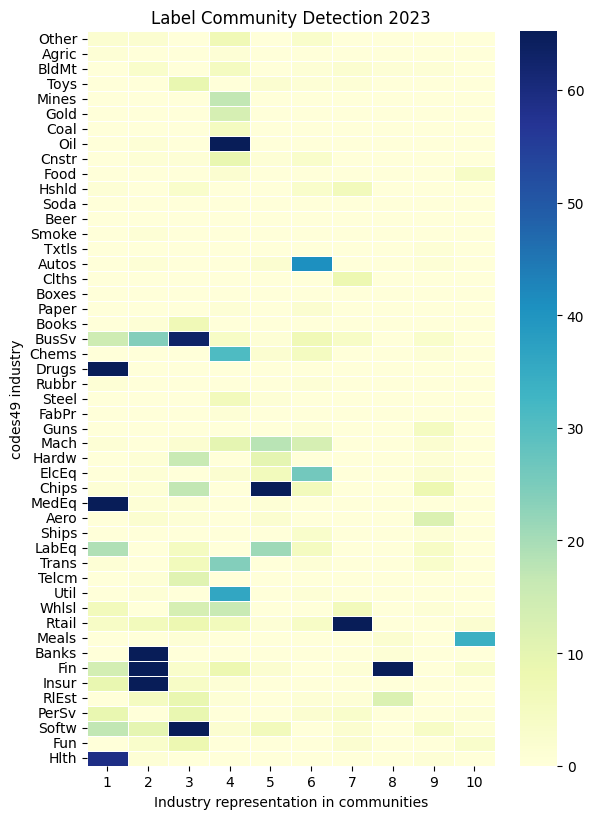

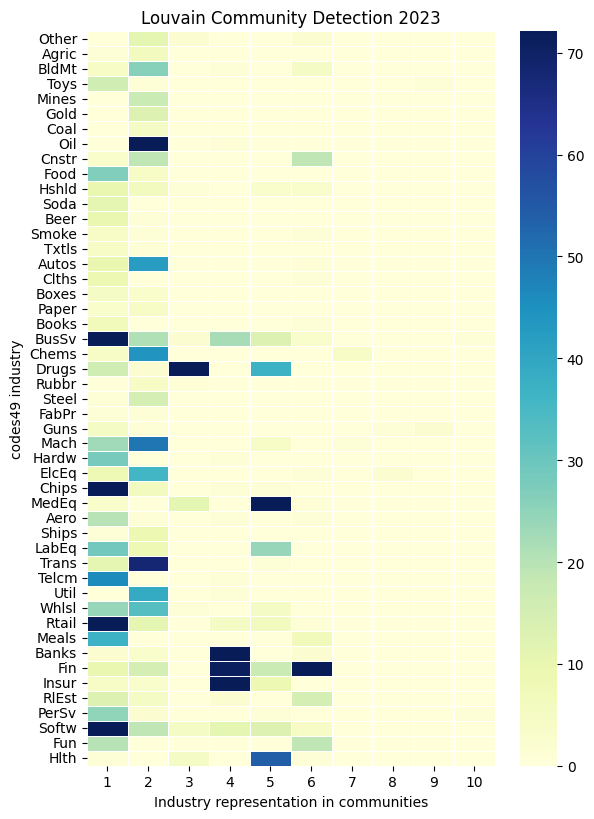

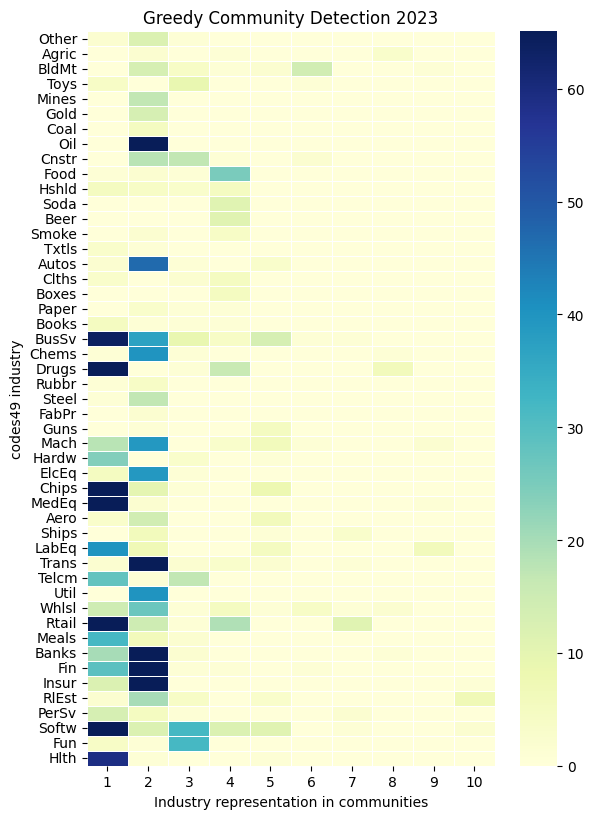

In [14]:
# Visualize Fama-French 49-industries in the detected communities
key = 'codes49'
for ifig, detection in enumerate(communities.keys()):

    # count industries represented in each partition
    industry = []
    communities_sequence = sorted(communities[detection], key=len, reverse=True)    
    for i, community in enumerate(communities_sequence):
        industry.append(nodes[key][list(community)].value_counts().rename(i+1))
    names = sectorings[key].sectors['name'].drop_duplicates(keep='first')
    df = pd.concat(industry, axis=1)\
           .dropna(axis=0, how='all')\
           .fillna(0)\
           .astype(int)\
           .reindex(names)

    # display as heatmap
    fig, ax = plt.subplots(num=ifig+1, clear=True, figsize=(6, 8))
    sns.heatmap(df.iloc[:,:10],
                square=False,
                linewidth=.5,
                ax=ax,
                yticklabels=1,
                cmap="YlGnBu",
                robust=True)
    if scheme.startswith('bea'):
        ax.set_yticklabels(Sectoring._bea_industry[df.index], size=10)
    else:
        ax.set_yticklabels(df.index, size=10)
    ax.set_title(f'{detection.capitalize()} Community Detection {year}')
    ax.set_xlabel(f"Industry representation in communities")
    ax.set_ylabel(f"{key} industry")
    fig.subplots_adjust(left=0.4)
    plt.tight_layout(pad=0)


**References**

Gerard Hoberg and Gordon Phillips, 2016, Text-Based Network Industries and Endogenous Product Differentiation.Journal of Political Economy 124 (5), 1423-1465.

Gerard Hoberg and Gordon Phillips, 2010, Product Market Synergies and Competition in Mergers and Acquisitions: A Text-Based Analysis. Review of Financial Studies 23 (10), 3773-3811. 